#### Code below is from given generate_lumpy_background.py file (just for visual reference)

import numpy as np

def generate_lumpy_background(dim=(64, 64), N_bar=15, a=1, w_b=3):
    """
    Generate a lumpy background based on a 2D Gaussian model

    Args:
    - dim (tuple): Dimensions of the background image
    - N_bar (int): Mean number of lumps (Poisson distribution parameter)
    - a (float): Lump amplitude
    - w_b (float): Lump width (standard deviation of Gaussian)

    Returns:
    - background (2D array): The generated lumpy background
    """
    N_b = np.random.poisson(N_bar)  # Number of lumps sampled from Poisson distribution
    background = np.zeros(dim)

    # Create lumps at random positions
    for _ in range(N_b):
        # Sample random position for the lump center
        r_n = np.random.randint(0, dim[0]), np.random.randint(0, dim[1])

        # Generate a Gaussian lump
        X, Y = np.meshgrid(np.arange(dim[0]), np.arange(dim[1]))
        r = np.stack([X, Y], axis=-1)
        dist = np.sum((r - r_n) ** 2, axis=-1)
        lump = a * np.exp(-dist / (2 * w_b ** 2))

        # Add lump to the background
        background += lump

    return background

In [83]:
import numpy as np, numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import os

In [84]:
from generate_lumpy_background import generate_lumpy_background

### Visualizing generate_lumpy_background()

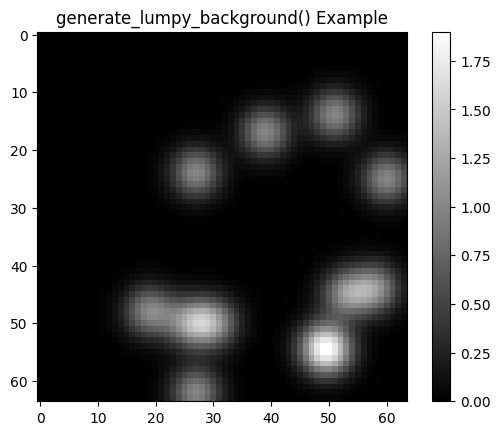

In [27]:
samp_bg = generate_lumpy_background()

plt.imshow(samp_bg,cmap='grey')
plt.title("generate_lumpy_background() Example")
plt.colorbar()
plt.show()

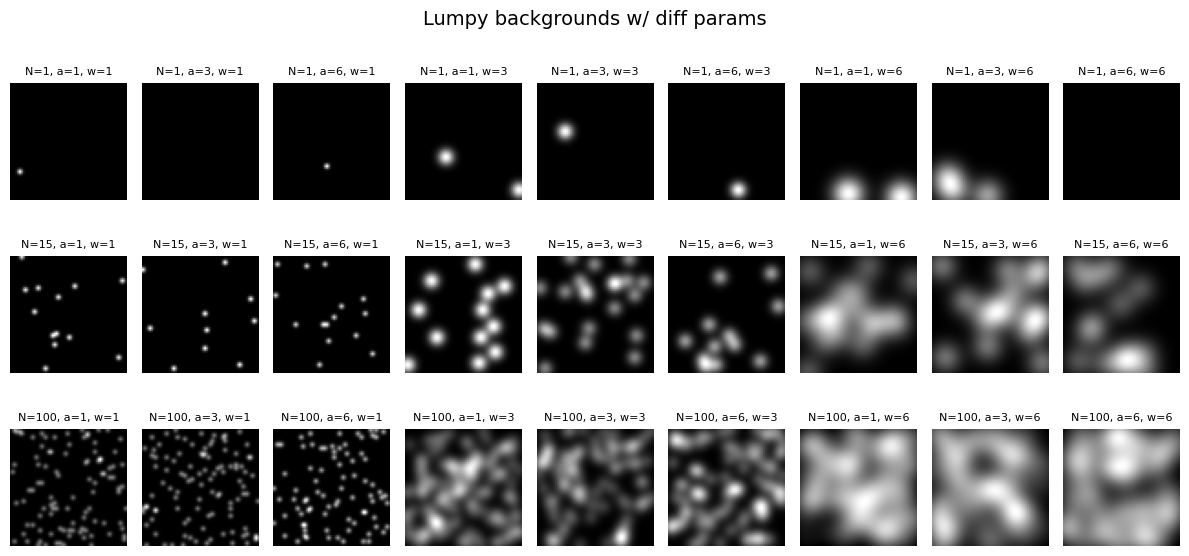

In [40]:
N_bar_vals = [1, 15, 100] # lump count
w_b_vals = [1, 3, 6]      # lump width
a_vals = [1, 3, 6]        # amplitude

fig, axs = plt.subplots(len(N_bar_vals),len(w_b_vals)*len(a_vals),figsize=(12, 6))
for i, N_bar in enumerate(N_bar_vals):
    for j, w_b in enumerate(w_b_vals):
        for k, a in enumerate(a_vals):
            idx = j * len(a_vals) + k
            ax = axs[i, idx]
            bg = generate_lumpy_background(dim=(64, 64), N_bar=N_bar, a=a, w_b=w_b)
            ax.imshow(bg, cmap='gray')
            ax.axis('off')
            ax.set_title(f'N={N_bar}, a={a}, w={w_b}', fontsize=8)

plt.suptitle("Lumpy backgrounds w/ diff params", fontsize=14)
plt.tight_layout()
plt.show()

### Dataset generation

In [48]:
def add_gaussian_blob(img, size=3,ampl=2):
    h, w = img.shape
    x_cent = h // 2
    y_cent = w // 2

    y_coords,x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')

    dist_sq = (x_coords - x_cent)**2 + (y_coords - y_cent)**2
    blob = ampl * np.exp(-dist_sq / (2 * size**2))

    return img + blob

In [70]:
def add_noise(img, noise_stdev):
    noise = np.random.normal(0, noise_stdev, img.shape)
    return img + noise

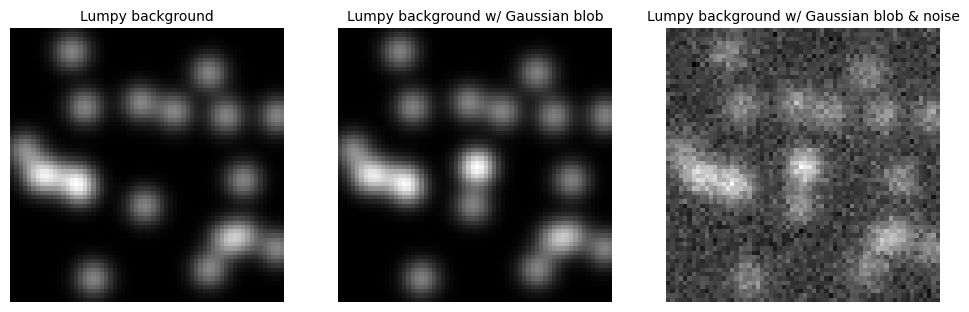

In [77]:
bg = generate_lumpy_background()
blob_img = add_gaussian_blob(bg)
noisy_img = add_noise(blob_img,0.2)

fig, ax = plt.subplots(1,3,figsize=(12, 4))
ax[0].imshow(bg,cmap='grey')
ax[0].set_title("Lumpy background",fontsize=10)
ax[0].axis('off')

ax[1].imshow(blob_img,cmap='grey')
ax[1].set_title("Lumpy background w/ Gaussian blob",fontsize=10)
ax[1].axis('off')

ax[2].imshow(noisy_img,cmap='grey')
ax[2].set_title("Lumpy background w/ Gaussian blob & noise",fontsize=10)
ax[2].axis('off')

plt.show()

In [87]:
def generate_dataset(N_samples, N_bar=15,a=1,w_b=3, signal_present=True,noise_stdev=1):
    data = []
    labels = []

    for i in range(N_samples):
        bg = generate_lumpy_background(N_bar=N_bar,a=a,w_b=w_b)
        
        if signal_present:
            bg = add_gaussian_blob(bg)
            labels.append(1)
        else:
            labels.append(0)
            
        noisy_img = add_noise(bg, noise_stdev)
        data.append(noisy_img.flatten())

    return np.array(data), np.array(labels)

In [133]:
# N = 11000
# train_chunk = 0.8

# N_train = int(N*train_chunk)
# N_test = N - N_train
N_train, N_test = 10000, 1000

In [134]:
# generating train data
X_train_none, y_train_none = generate_dataset(N_train, signal_present=False)
X_train_signal, y_train_signal = generate_dataset(N_train, signal_present=True)

X_train = np.vstack([X_train_none, X_train_signal])
y_train = np.concatenate([y_train_none, y_train_signal])
X_train, y_train = shuffle(X_train, y_train, random_state=11)

In [135]:
# generating test data
X_test_none, y_test_none = generate_dataset(N_test, signal_present=False)
X_test_signal, y_test_signal = generate_dataset(N_test, signal_present=True)

X_test = np.vstack([X_test_none, X_test_signal])
y_test = np.concatenate([y_test_none, y_test_signal])
X_test, y_test = shuffle(X_test, y_test, random_state=11)

In [136]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20000, 4096), (20000,), (2000, 4096), (2000,))

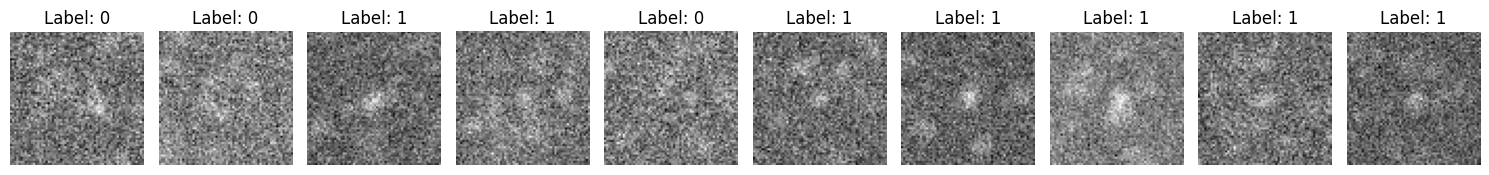

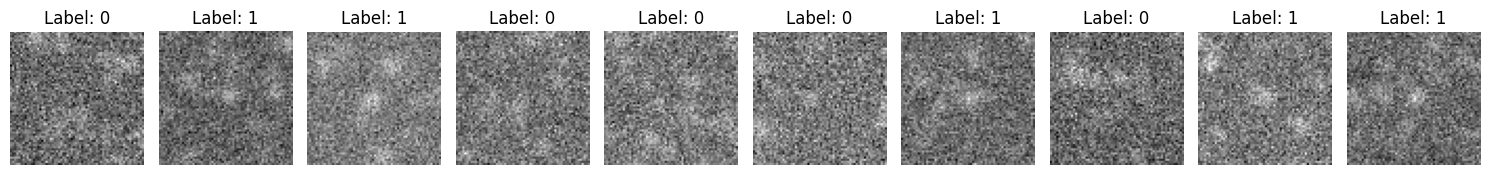

In [137]:
def show_images(images, labels, n=10):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(64, 64), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_images(X_train, y_train)
show_images(X_test, y_test)

### Hotelling Observer

In [138]:
def hotelling_observer(X_train, y_train, X_test):
    X_0 = X_train[y_train == 0]
    X_1 = X_train[y_train == 1]

    mean_0 = np.mean(X_0, axis=0)
    mean_1 = np.mean(X_1, axis=0)

    cov = np.cov(X_train.T)
    cov_inv = np.linalg.pinv(cov)
    
    w = cov_inv @ (mean_1 - mean_0)

    scores = X_test @ w
    return scores

In [139]:
scores_ho = hotelling_observer(X_train, y_train, X_test)

auc_ho = roc_auc_score(y_test, scores_ho)
print("HO AUC:", auc_ho)

HO AUC: 0.998404
